# In-beam imaging

This notebook shows an example of in-beam imaging with the spatial- and frequency-domain interferometry (SDI + FDI) using Capon method.

---

We use `jax.jit` to speed-up the comptuation of the Capon method.

In [1]:
from os.path import join, dirname
import numpy as np
import matplotlib.pyplot as plt
from antarrlib import freq2wlen, freq2wnum, radial, incirc_trigrid, dB, SPEED_OF_LIGHT as c0

try:
    import jax.numpy as jnp
    from jax import jit, vmap

    @jit
    def capon(rxx_i, a):
        """Capon beamformer.
        
        Parameters
        ==========
        rxx_i: array of complex of the size [M, M]
            Inverse of the variance-covariance matrix of the received signals, where `M` is the number of channels.
        a: array of complex of the size [N, M]
            Steering vector for `N` set of conditions.
        
        Returns
        =======
        spc: array of float of the size [N]
            Capon spectrum for `N` set of conditions.
        """
        rxx_i = jnp.array(rxx_i)
        a = jnp.array(a)

        def capon_each(a1):
            return 1 / jnp.abs(a1.conj().T @ rxx_i @ a1.T)

        return vmap(capon_each)(a)

except ImportError:
    from warnings import warn

    def capon(rxx_i, a):
        "Fallback version of capon when jax was not found."
        warn("jax is not installed, falling back to native loop implementation.")

        y = []
        for a1 in a:
            y.append(1 / np.abs(a1.conj().T @ rxx_i @ a1.T))
        return np.array(y)

## Target settings

A point source is at some distance from the radar, displaced a little horizontally.

In [2]:
target_x = 2000  # m
target_y = 3000  # m
target_altitude = 80e3  # [m]
target_position = np.array([target_x, target_y, target_altitude])

# True target direction and distance.
ze0 = np.arccos(target_position[2] / np.linalg.norm(target_position, axis=-1))
az0 = np.arctan2(target_position[1], target_position[0])

target_distance = np.linalg.norm(target_position)
print("Target:")
print(f"  True distance: {target_distance/1e3:.03f} km")
print(f"  True direction (ze, az): {np.rad2deg(ze0):.02f}°, {np.rad2deg(az0):.02f}°")

Target:
  True distance: 80.081 km
  True direction (ze, az): 2.58°, 56.31°


## Range gate setting

By default, the target is at the center of the range gate.  
It can be moved with the specified offset ratio.

In [3]:
range_gate_width = 2e-6
# Default range gate's lower bound.
# Target will be at the center of the range gate.
range_gate_lo = target_altitude - range_gate_width / 2 * c0
# Target position offset ratio within range gate [-1, 1]
offset_ratio = 0.0
range_gate_lo += range_gate_width / 2 * c0 * -offset_ratio/2

## Radar setting

Wavenumber vector $\mathbf{k}$ is defined as:

$$
\mathbf{k} = \left[ k_1, k_2, \cdots \right]
$$

where

$$
k_i = \frac{2 \pi (f_0 + f_{i})}{c_0}
$$

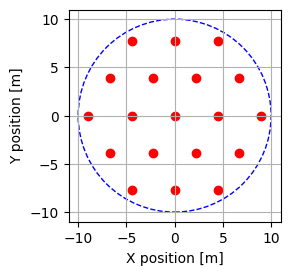

In [4]:
f0 = 47e6  # Center frequency [Hz]
freq_offsets = np.array([-500e3, -250e3, 0, 250e3, 500e3])   # Frequency offsets [Hz]
num_freqs = len(freq_offsets)

# Wavenumber for each frequency.
k = freq2wnum(f0 + freq_offsets)

# Antenna settings.
lambda_ = freq2wlen(f0)  # wavelength [m]
radius = 10  # [m]
antenna_positions = incirc_trigrid(lambda_ * 0.7, radius)
num_antennas = len(antenna_positions)

fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(antenna_positions[:, 0], antenna_positions[:, 1], c='red', marker='o')
ax.add_patch(plt.Circle((0, 0), radius, color='blue', fill=False, linestyle='dashed'))
ax.set_xlabel("X position [m]")
ax.set_ylabel("Y position [m]")
ax.set_aspect('equal')
ax.grid()
fig.tight_layout()

## Signal generation

In [5]:
# Generate received signals for each frequency and antenna [num_freqs, num_antennas]
tx_distance = np.linalg.norm(target_position)
rx_distance = np.linalg.norm(antenna_positions - target_position, axis=-1)
distance = tx_distance + rx_distance
received_signals = np.exp(1j * k[:, None] * distance[None, :])

## Steering vector

Evaluation grid for angles and ranges are generated.

For range imaging, we divide a range gate into $n_{r}$ sub range gates $\mathbf{r} = [r_1, r_2, \cdots]$.

For each beam pointing angle $(\theta_l, \phi_l)$ and sub range gate $r_l$, the steering vector for frequency index $m$ and antenna index $n$ is:

$$
A_{m, n}(\theta_l, \phi_l, r_l) = \exp \mathrm{j} k_m \left\{ r_l +  \left \Vert r_l \mathbf{V}(\theta_l, \phi_l) - \mathbf{L}_n \right \Vert_2 \right\}
$$

where $\mathbf{L}_n$ is the location of $n$-th antenna and $\mathbf{V}(\theta_l, \phi_l)$ is the radial vector to the direction $(\theta_l, \phi_l)$.

In [6]:
# The number of subranges.
# Each range gate is divided into this number of subranges.
nsubr = 32

# Index offset of subranges [nsubr].
csubr = (np.arange(nsubr) - nsubr/2 + 0.5) / nsubr + 0.5

# Range evaluation grid.
r_m = range_gate_lo + csubr * range_gate_width * c0

# Angular evaluation grid.
ze_deg = np.linspace(0, 15, 31)
az = np.linspace(-np.pi, np.pi, 361)

# Final evaluation grid.
ze_g, az_g, r_g = np.meshgrid(np.deg2rad(ze_deg), az, r_m, indexing="ij")

# Steering vector.
tx_distance = r_g.ravel()[:, None]
rx_positions = radial(ze_g, az_g) * r_g.ravel()[:, None]
rx_distance = np.linalg.norm(rx_positions[:, None, :] - antenna_positions[None, ...], axis=-1)
distance = tx_distance + rx_distance
a = np.exp(1j * k[None, :, None] * distance[..., None, :])

## Imaging techniques

Here, we use two methods and compares results.

### Fourier method

The simplest back-projection method.

$$
y = \mathbf{A}^\mathrm{H} \mathbf{X}
$$

### Capon method

Linearly-constrained minimization of power.

$$
y = \frac{1}{\mathbf{A}^\mathrm{H} \mathsf{R}_{xx}^{-1} \mathbf{A}}
$$

In [7]:
# Fourier method.
y = np.abs(np.sum(a.conj() * received_signals[None, ...], axis=(1, 2)))**2
y.shape = ze_g.shape

# Capon method.
nchan = num_antennas * num_freqs
x = received_signals.ravel()
rxx_i = np.linalg.inv(x[:, None].dot(x.conj()[None, :]) + 1e-4 * np.eye(nchan))
aa = a.reshape(-1, nchan)
y2 = capon(rxx_i, aa).reshape(ze_g.shape)

## Plotting

In [8]:
# Determin nrows and ncols in the figure.
# nrow = int(np.sqrt(nsubr))
nrow = 4
ncol = nsubr // nrow
if nrow * ncol < nsubr:
    ncol += 1


# Plotting method.
def plot_images(y):
    # Color range.
    noi = np.median(y)
    y_dB = dB(y, noi)
    ymax = np.max(y_dB)
    ymaxs = np.max(y, axis=(0, 1))

    fig, axes = plt.subplots(nrow, ncol, figsize=(12, 8), subplot_kw=dict(projection="polar"))
    for ax in axes.flat:
        ax.set_thetagrids([], [])
        ax.set_rgrids([], [])
    for i, raxis1 in enumerate(r_m):
        p = y_dB[..., i]
        ax = axes.flat[i]
        ax.pcolormesh(az, ze_deg, p, vmin=0, vmax=ymax)
        ax.set_title(f"{raxis1/1e3:.02f} km")
        ax.set_thetagrids(range(0, 360, 45), [])
        ax.set_rgrids(range(0, 90, 10), [])
        ax.plot(az0, np.rad2deg(ze0), "ro", mfc="none", ms=10)
    fig.tight_layout()
    return ymaxs

### Fourier method

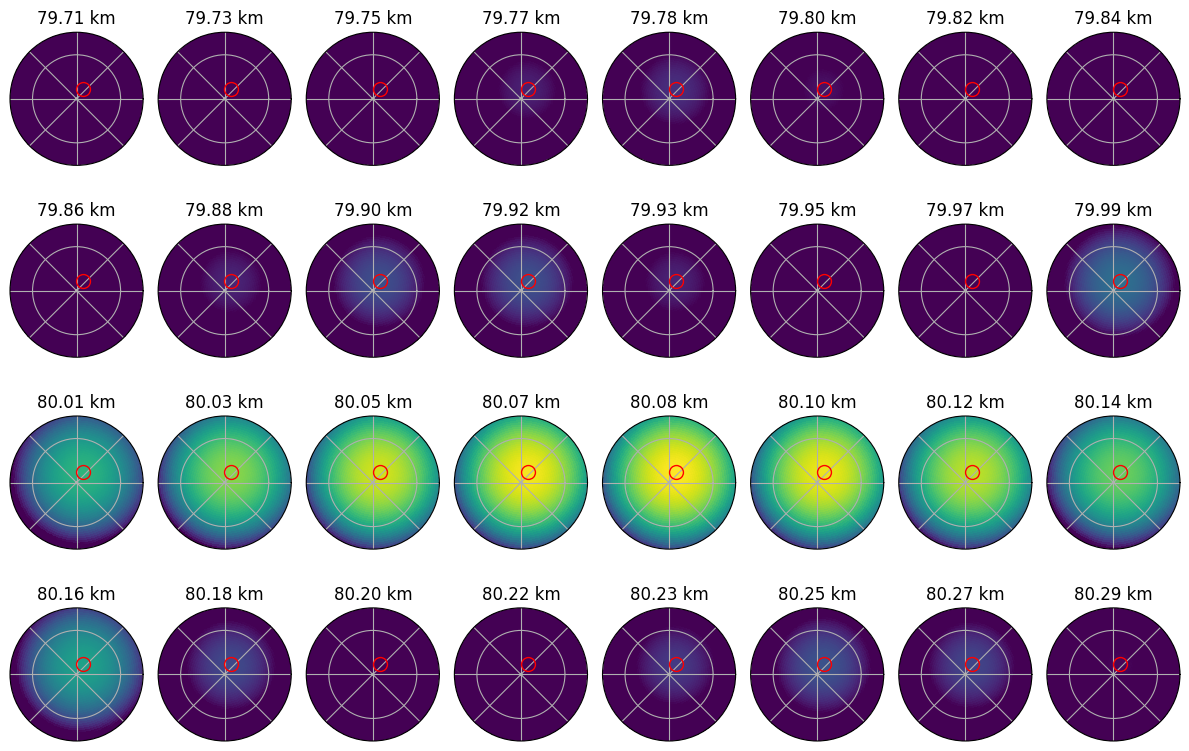

In [9]:
ymaxs = plot_images(y)

### Capon method

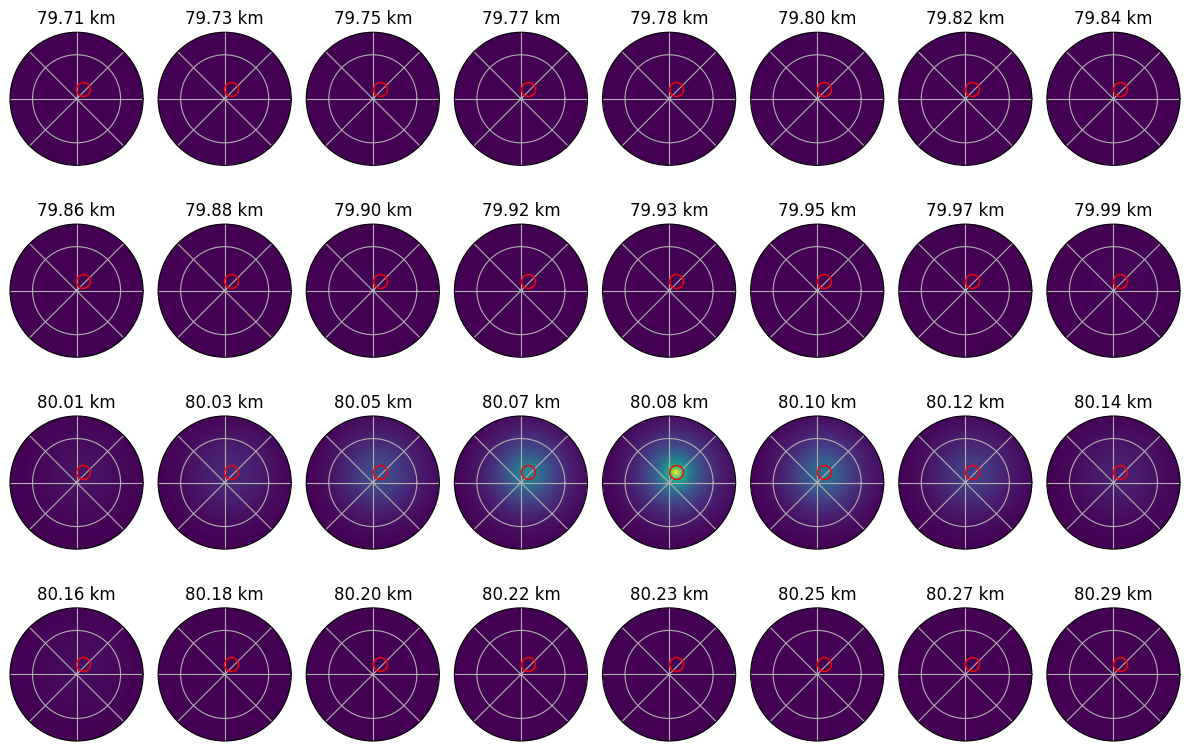

In [12]:
ymaxs2 = plot_images(y2)

### Comparison

Peak power at each subrange gate are compared.  
Peak of each line plot is normalized to 0 dB.

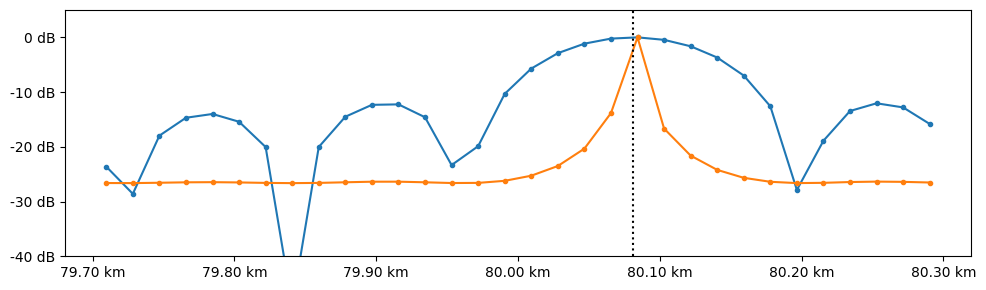

In [11]:
ymaxs_dB = dB(ymaxs, "max")
ymaxs2_dB = dB(ymaxs2, "max")
plt.figure(figsize=(10, 3))
plt.plot(r_m/1e3, ymaxs_dB, marker=".")
plt.plot(r_m/1e3, ymaxs2_dB, marker=".")
plt.axvline(target_distance/1e3, c="k", ls=":")
plt.gca().xaxis.set_major_formatter("{x:.2f} km")
plt.gca().yaxis.set_major_formatter("{x:.0f} dB")
plt.ylim(-40, 5)
plt.tight_layout()